In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

from sklearn.preprocessing import LabelEncoder

## Define functions

In [348]:
def string2date(str_date):
    """
    Convert date from string format to datetime format
    """
    try: #if the str_date has the format 'int-int-int'
        int_date = map(lambda x:int(x),str_date.split('/'))
        return dt.date(int_date[2],int_date[0],int_date[1])
    except:#otherwise return the date as given and print it for debugging 
        print str_date
        return str_date

def percConvert(series):
    """
    Function to normalize series where the last element is the sum of other elements
    """
    return series/float(series[-1])

def rand_jitter(arr,degree=0.01):
    """
    Add noise to a series of data. This will be used to scatter plot. (refer to ggplot jitter)
    arr: numpy.array or pd.Series, input data
    degree: float, degree of randomness which scales with respect to the stdev of the series
    """
    stdev = np.std(arr)*degree
    return arr+np.random.randn(len(arr))*stdev

def pc_to_name(pin,pin_directory,div="statename"):
    """
    convert a pin code to name of administrative division
    """
    #print pin
    if div in pin_directory.columns:
        df = pin_directory[pin_directory.pincode == pin][div].dropna()
        if df.shape[0]== 0:
            return "Unknown"
        elif df.shape[0] == 1:
            return df.values[0]
        else:
            try:
                return df.mode()[0]
            except:
                return df.values[-1]
    else:
        #print "<----"
        return np.nan


In [309]:
# import data
df_train = pd.read_csv('data/Train_pjb2QcD.csv')
df_test = pd.read_csv('data/Test_wyCirpO.csv')
df_pin_code = pd.read_csv('data/all_india_PO_list_without_APS_offices_ver2_lat_long.csv')

### Dataset description

In [310]:
print "**size for:\n\tTrain:{0}\n\tTest{1}".format(df_train.shape,df_test.shape)


**size for:
	Train:(9527, 23)
	Test(5045, 22)


In [311]:
# preview dataset
df_train.head().T

,0,1,2,3,4
ID,FIN1000001,FIN1000002,FIN1000003,FIN1000004,FIN1000005
Office_PIN,842001,842001,800001,814112,814112
Application_Receipt_Date,4/16/2007,4/16/2007,4/16/2007,4/16/2007,4/16/2007
Applicant_City_PIN,844120,844111,844101,814112,815351
Applicant_Gender,M,M,M,M,M
Applicant_BirthDate,12/19/1971,2/17/1983,1/16/1966,2/3/1988,7/4/1985
Applicant_Marital_Status,M,S,M,S,M
Applicant_Occupation,Others,Others,Business,Salaried,Others
Applicant_Qualification,Graduate,Class XII,Class XII,Class XII,Class XII
Manager_DOJ,11/10/2005,11/10/2005,5/27/2006,8/21/2003,5/8/2006


#### - rename some columns for an easy future exploration

In [312]:
df_train.rename(columns={'Applicant_BirthDate':'Applicant_DoB','Manager_DOJ':'Manager_DoJ'}, inplace=True)

#### - Missing values and unique values
For each column we print the number of missing values as well as the number of unique values

In [319]:
miss_uniq_vals = []
for col in df_train.columns:
    miss_uniq_vals.append((100*len(df_train[df_train[col].isnull()])/float(df_train.shape[0]),len(pd.unique(df_train[col]))))
miss_uniq_vals = pd.DataFrame(miss_uniq_vals)
miss_uniq_vals.index = df_train.columns.tolist()
miss_uniq_vals.columns = ['perc_missing_val','num_uniq_val']
miss_uniq_vals

,perc_missing_val,num_uniq_val
ID,0.0,9527
Office_PIN,0.0,98
Application_Receipt_Date,0.0,357
Applicant_City_PIN,0.0,2979
Applicant_Gender,0.0,2
Applicant_DoB,0.0,5836
Applicant_Marital_Status,0.0,4
Applicant_Occupation,0.0,5
Applicant_Qualification,0.0,11
Manager_DoJ,0.0,646


Let's now impute missing values in each column. I will replace missing values by the most frequent value of the corresponding column

In [314]:
imputers = {}
for col in df_train.columns:
    if miss_uniq_vals.loc[col,'perc_missing_val']>0:
        # uncomment these lines to check the number of missing values before and after imputation
        #print col,'\t',df_train[df_train[col].isnull()].shape[0],'\t',
        most_freq = df_train[col].mode()[0]
        df_train[col].replace(np.nan,most_freq,inplace=True)
        imputers[col] = most_freq
        #print df_train[df_train[col].isnull()].shape[0]

#### - Data types

In [315]:
data_types = {
    'dates':['Application_Receipt_Date','Applicant_DoB','Manager_DoJ','Manager_DoB'],
    'unordered_cat':['Office_PIN','Applicant_City_PIN','Applicant_Gender','Applicant_Marital_Status',
                   'Applicant_Occupation','Applicant_Qualification','Manager_Status','Manager_Gender',
                   'Business_Sourced'],
    'ordered_cat':['Manager_Joining_Designation','Manager_Current_Designation'],
    'integers':['Manager_Grade','Manager_Num_Application','Manager_Num_Coded','Manager_Num_Products',
                'Manager_Num_Products2','Manager_Business','Manager_Business2']
}

Now, we convert each column to its proper data type and prepare a label encoder to transform categorical into numeric. this will be used later

In [316]:
label_encoders = {}
for col in df_train.columns[:-1]: # dont convert target column yet
    if col in data_types['dates']:
        df_train[col] = df_train[col].apply(lambda x:string2date(x))
    if col in data_types['ordered_cat']:
        df_train[col] = pd.Categorical(df_train[col],ordered=True)
        label_encoders[col] = LabelEncoder()
        label_encoders[col].fit(df_train[col])
    if col in data_types['unordered_cat']:
        df_train[col] = pd.Categorical(df_train[col],ordered=False)
        label_encoders[col] = LabelEncoder()
        label_encoders[col].fit(df_train[col])
    if col in data_types['integers']:
        df_train[col] = df_train[col].astype(int)

### Univariate Data Exploration and Engineering

#### - Target label

In [317]:
print "The probability of picking a positive Business Sourced is",df_train[df_train.Business_Sourced == 1].shape[0]/float(df_train.shape[0])

The probability of picking a positive Business Sourced is 0.342920121759


#### - Date type

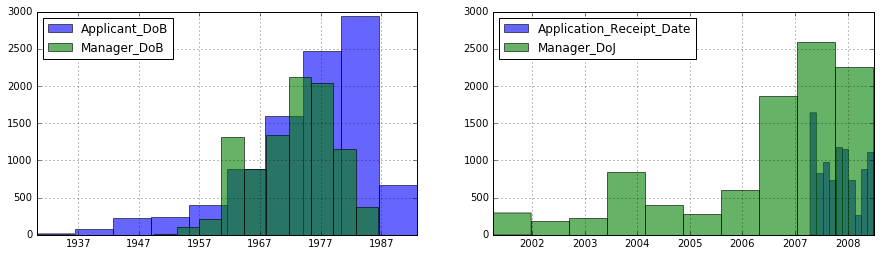

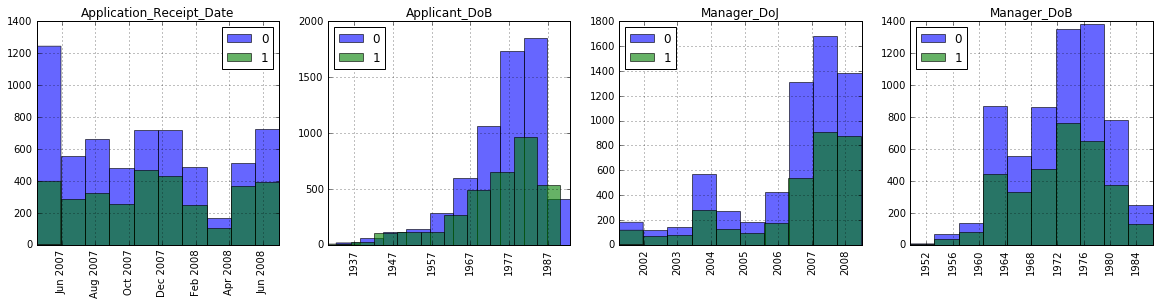

In [318]:
# We plot earlier (date of births) and later dates separately
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
legends1 = []
legends2 = []
for col in data_types['dates']:
    if 'DoB' in col:
        df_train[col].hist(alpha=0.6,ax=ax1)
        legends1.append(col)
    else:
        df_train[col].hist(alpha=0.6,ax=ax2)
        legends2.append(col)
ax1.legend(legends1,loc='best')
ax2.legend(legends2,loc='best')
plt.show()

# plot, the target label as function of each date column
fig, ax = plt.subplots(1,4,figsize=(20,4))
for col in data_types['dates']:
    df_train[col][df_train.Business_Sourced == 0].hist(alpha = 0.6,ax=ax[data_types['dates'].index(col)],xrot=90)
    df_train[col][df_train.Business_Sourced == 1].hist(alpha = 0.6,ax=ax[data_types['dates'].index(col)],xrot=90)
    #ax[data_types['dates'].index(col)].plot(df_train[col],df_train.Business_Sourced,'bo',alpha = 0.5)
    ax[data_types['dates'].index(col)].set_title(col)
    ax[data_types['dates'].index(col)].legend([0,1],loc='best')
plt.show()



- Approximately applicants are about 10 years younger managers (top-left figure)
- There was a hug increase in hiring managers starting with mid 2006, followed by hiring new applicants as well in 2007. However it looks like the number of applicants started to decrease in beginning 2008

It would also be interesting to look at:
- Difference in age between manager and applicant
- Look at Business Sourced as function of just years or months (but not dates)
- Manager's experience time with the firm. This is the time between Applicant's receipt date and when the manager joined. **Note**: Some value may turn to be negative. This would mean that the manager joined after an application has been filed

So, let's create new data columns first

In [257]:
df_train['Applicant_Manager_DA'] = np.array(map(lambda x:float(x.days),df_train.Applicant_DoB - df_train.Manager_DoB))/365.0
df_train['Applicant_DoB_Year'] = df_train.Applicant_DoB.apply(lambda x:x.year)
df_train['Manager_DoB_Year'] = df_train.Manager_DoB.apply(lambda x:x.year)
df_train['Applicant_RD_Month'] = df_train.Application_Receipt_Date.apply(lambda x:x.month)
df_train['Manager_DoJ_Year'] = df_train.Manager_DoJ.apply(lambda x:x.year)
df_train['Manager_Experience'] = np.array(map(lambda x:x.days,df_train.Application_Receipt_Date - df_train.Manager_DoJ))/365.0
new_cols = ['Applicant_Manager_DA','Applicant_DoB_Year','Manager_DoB_Year','Applicant_RD_Month','Manager_DoJ_Year','Manager_Experience']

In [258]:
df_train[new_cols].describe()

,Applicant_Manager_DA,Applicant_DoB_Year,Manager_DoB_Year,Applicant_RD_Month,Manager_DoJ_Year,Manager_Experience
count,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000
mean,2.938533,1974.817046,1971.904062,6.714601,2005.894825,1.397478
std,11.553439,10.257713,6.812725,3.129828,1.777298,1.697698
min,-47.090411,1930.000000,1949.000000,1.000000,2001.000000,-0.230137
25%,-2.854795,1970.000000,1967.000000,5.000000,2005.000000,0.115068
50%,3.545205,1978.000000,1973.000000,6.000000,2007.000000,0.693151
75%,10.234247,1982.000000,1977.000000,9.000000,2007.000000,1.967123
max,35.430137,1992.000000,1986.000000,12.000000,2008.000000,7.194521


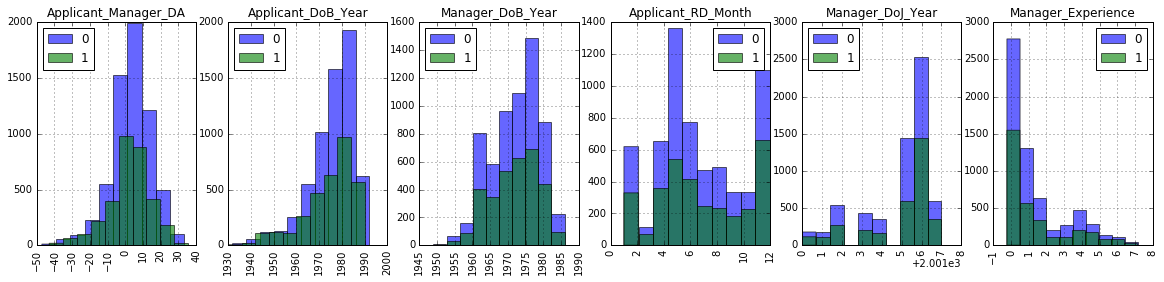

In [259]:
fig, ax = plt.subplots(1,6,figsize=(20,4))
for col in new_cols:
    df_train[col][df_train.Business_Sourced == 0].hist(alpha = 0.6,ax=ax[new_cols.index(col)],xrot=90)
    df_train[col][df_train.Business_Sourced == 1].hist(alpha = 0.6,ax=ax[new_cols.index(col)],xrot=90)
    #ax[data_types['dates'].index(col)].plot(df_train[col],df_train.Business_Sourced,'bo',alpha = 0.5)
    ax[new_cols.index(col)].set_title(col)
    ax[new_cols.index(col)].legend([0,1],loc='best')
plt.show()

--> Not enough additional insights :-(

#### - Ordered categorical data

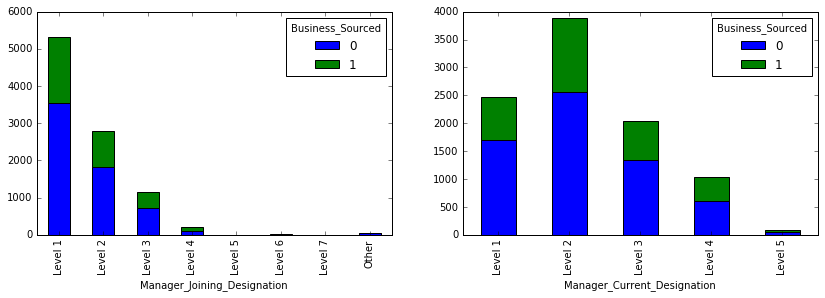

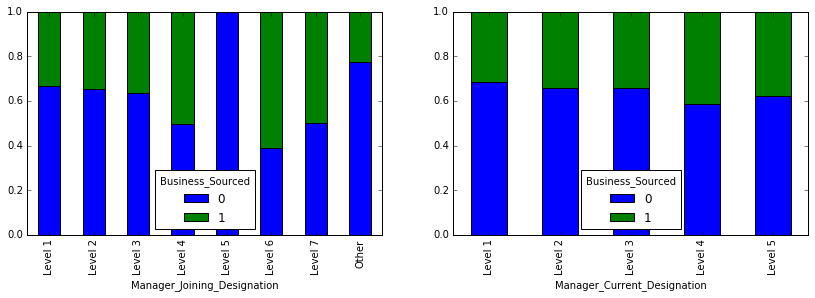

In [260]:
#print "Un-normalized"
fig,ax = plt.subplots(1,2,figsize = (14,4))
for col in data_types['ordered_cat']:
    #generate cross table first
    ct = pd.crosstab(df_train[col],df_train['Business_Sourced'],margins=True)
    #normalize
    #ct = ct.apply(percConvert,axis=1)
    ct.iloc[:-1,:-1].plot(kind='bar',stacked=True, ax=ax[data_types['ordered_cat'].index(col)])
#print "Normalized"
fig,ax = plt.subplots(1,2,figsize = (14,4))
for col in data_types['ordered_cat']:
    #generate cross table first
    ct = pd.crosstab(df_train[col],df_train['Business_Sourced'],margins=True)
    #normalize
    ct = ct.apply(percConvert,axis=1)
    ct.iloc[:-1,:-1].plot(kind='bar',stacked=True, ax=ax[data_types['ordered_cat'].index(col)])

We would also be interested to see how a manager has progressed in levels since he joined until the application receipt date. To make it fancy this can be  normalized over the time he has been with the firm. **Note**: To avoid infinite rate (managers with 0 years of experience with the firm), we cheat and add one day to the manager experience

In [261]:
c1 = 'Manager_Current_Designation'
c2 = 'Manager_Joining_Designation'
df_train['Manager_Promotion'] = label_encoders[c1].transform(df_train[c1]) - label_encoders[c2].transform(df_train[c2])
# calculate the promotion (yearly) rate. 
df_train['Manager_Promotion_Rate'] = df_train['Manager_Promotion']/(df_train['Manager_Experience']+(1/365.0))
print df_train[['Manager_Promotion','Manager_Promotion_Rate']].describe()

       Manager_Promotion  Manager_Promotion_Rate
count        9527.000000             9527.000000
mean            0.549071                0.445504
std             0.995624                8.594634
min            -7.000000             -182.500000
25%             0.000000                0.000000
50%             0.000000                0.000000
75%             1.000000                0.424913
max             4.000000              365.000000


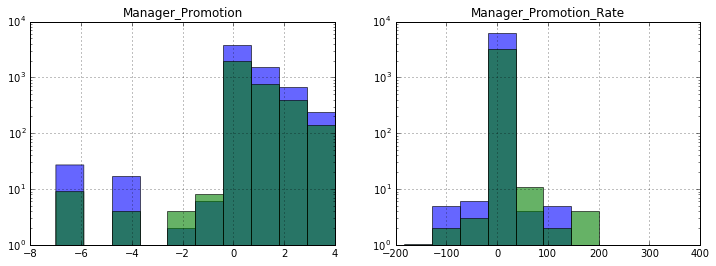

In [262]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
col = 'Manager_Promotion'
df_train[col][df_train.Business_Sourced == 0].hist(alpha = 0.6,ax=ax[0])
df_train[col][df_train.Business_Sourced == 1].hist(alpha = 0.6,ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title(col)

col = 'Manager_Promotion_Rate'
df_train[col][df_train.Business_Sourced == 0].hist(alpha = 0.6,ax=ax[1])
df_train[col][df_train.Business_Sourced == 1].hist(alpha = 0.6,ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title(col)
plt.show()

#### - Unordered categorical data


In [263]:
print miss_uniq_vals.loc[[i for i in data_types['unordered_cat']]]

                          perc_missing_val  num_uniq_val
Office_PIN                        0.000000            98
Applicant_City_PIN                1.018159          2980
Applicant_Gender                  0.703264             3
Applicant_Marital_Status          0.766243             5
Applicant_Occupation             12.816207             6
Applicant_Qualification           0.902698            12
Manager_Status                    7.169098             3
Manager_Gender                    7.169098             3
Business_Sourced                  0.000000             2



Let's separate columns in two groups: Those with unique values < 10 and another group of the rest (we will have to create new bins)

In [264]:
group1 = ['Applicant_Gender','Applicant_Marital_Status','Applicant_Occupation','Manager_Status','Manager_Gender','Applicant_Qualification']


For Applicant Qualification, let's bin together "MBA, Profession and Associates" in one bin called Class Y. Thereafter, we will have to re-fit the corresponding label encoder and replot

In [265]:
df_train.Applicant_Qualification.replace('Masters of Business Administration','Class Y', inplace=True)
df_train.Applicant_Qualification.replace('Associate / Fellow of Institute of Chartered Accountans of India','Class Y', inplace=True)
df_train.Applicant_Qualification.replace('Professional Qualification in Marketing','Class Y', inplace=True)
df_train.Applicant_Qualification.replace('Certified Associateship of Indian Institute of Bankers','Class Y', inplace=True)
df_train.Applicant_Qualification.replace('Associate/Fellow of Insurance Institute of India','Class Y', inplace=True)
df_train.Applicant_Qualification.replace('Associate/Fellow of Acturial Society of India','Class Y', inplace=True)
df_train.Applicant_Qualification.replace('Associate/Fellow of Institute of Company Secretories of India','Class Y', inplace=True)

df_train.Applicant_Qualification = pd.Categorical(df_train.Applicant_Qualification,ordered=False)
label_encoders['Applicant_Qualification'].fit(df_train.Applicant_Qualification)

LabelEncoder()

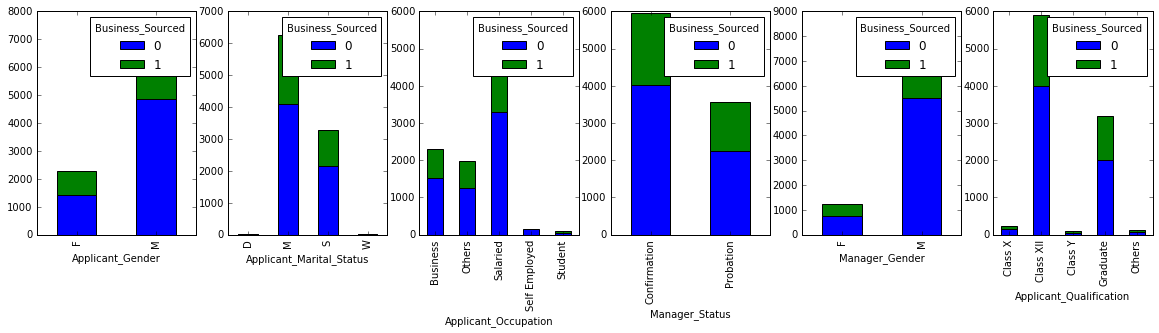

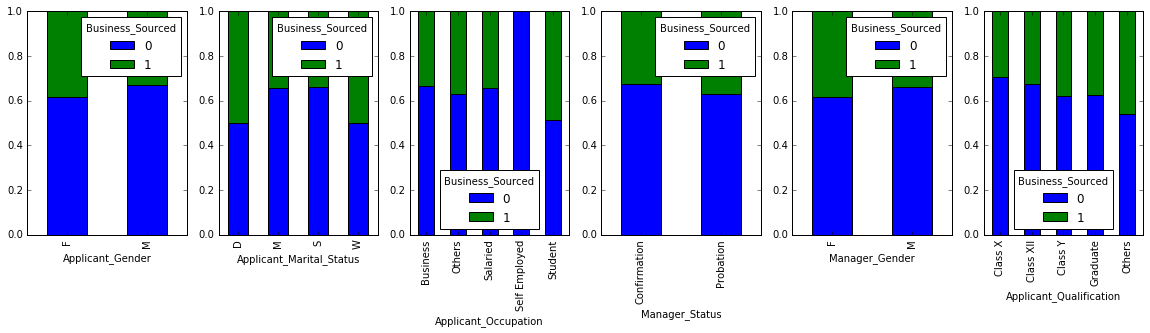

In [266]:
fig,ax = plt.subplots(1,len(group1),figsize = (20,4))
for col in group1:
    #generate cross table first
    ct = pd.crosstab(df_train[col],df_train['Business_Sourced'],margins=True)
    #normalize
    #ct = ct.apply(percConvert,axis=1)
    ct.iloc[:-1,:-1].plot(kind='bar',stacked=True, ax=ax[group1.index(col)])

fig,ax = plt.subplots(1,len(group1),figsize = (20,4))
for col in group1:
    #generate cross table first
    ct = pd.crosstab(df_train[col],df_train['Business_Sourced'],margins=True)
    #normalize
    ct = ct.apply(percConvert,axis=1)
    ct.iloc[:-1,:-1].plot(kind='bar',stacked=True, ax=ax[group1.index(col)])

- More males than females but they are all almost equally productive
- More married and singles than divorced and widows. Moreorver, married and singles are the most productive
- Self employed and students are the fewer applicants of the firm. Interestingly, students are the most productive of all the employees while self-employed applicants are the most unproductive
- Among the most hired classed, Graduates are the most efficient at sourcing business.

Next we create new columns to contain state names and then plot charts

In [349]:
### convert pin code to district names
df_train["Applicant_Districtname"] = df_train.Applicant_City_PIN.apply(lambda x: pc_to_name(x,df_pin_code,div="Districtname"))
df_train["Office_Districtname"] = df_train.Office_PIN.apply(lambda x: pc_to_name(x,df_pin_code,div="Districtname"))
df_train["Applicant_Statename"] = df_train.Applicant_City_PIN.apply(lambda x: pc_to_name(x,df_pin_code,div="statename"))
df_train["Office_Statename"] = df_train.Office_PIN.apply(lambda x: pc_to_name(x,df_pin_code,div="statename"))

In [350]:
print "col\tmissing_vals\tuniq_vals"
group2 = ['Applicant_Statename','Office_Statename','Applicant_Districtname','Office_Districtname']
for col in group2:
    print col,"\t",100*len(df_train[df_train[col].isnull()])/float(df_train.shape[0]),"\t",len(pd.unique(df_train[col]))

col	missing_vals	uniq_vals
Applicant_Statename 	0.0 	27
Office_Statename 	0.0 	23
Applicant_Districtname 	0.0 	340
Office_Districtname 	0.0 	93


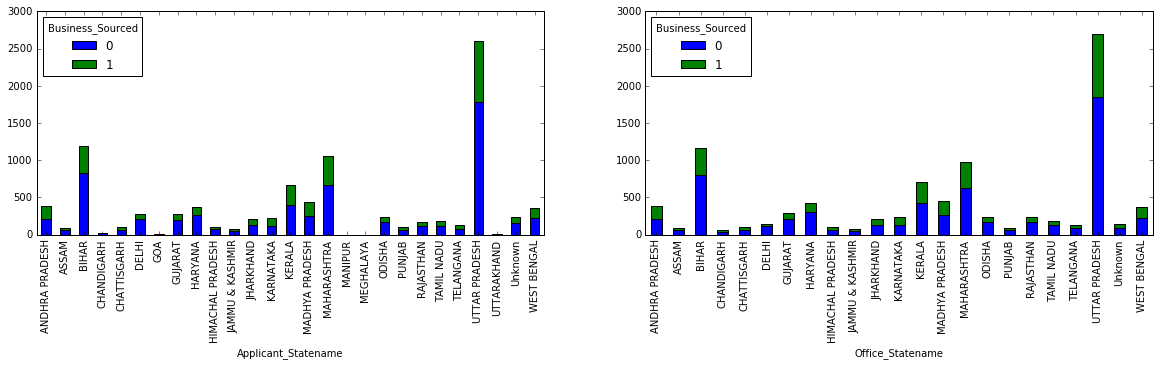

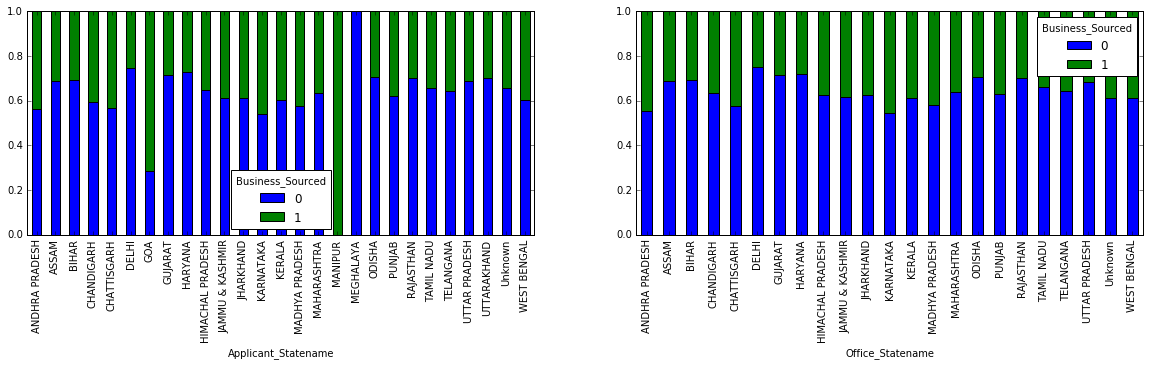

In [353]:
fig,ax = plt.subplots(1,len(group2[:2]),figsize = (20,4))
for col in group2[:2]:
    #generate cross table first
    ct = pd.crosstab(df_train[col],df_train['Business_Sourced'],margins=True)
    #normalize
    #ct = ct.apply(percConvert,axis=1)
    ct.iloc[:-1,:-1].plot(kind='bar',stacked=True, ax=ax[group2.index(col)])

fig,ax = plt.subplots(1,len(group2[:2]),figsize = (20,4))
for col in group2[:2]:
    #generate cross table first
    ct = pd.crosstab(df_train[col],df_train['Business_Sourced'],margins=True)
    #normalize
    ct = ct.apply(percConvert,axis=1)
    ct.iloc[:-1,:-1].plot(kind='bar',stacked=True, ax=ax[group2.index(col)])

What happen to agents working in different states than their address? What is the impact of them being single or married?

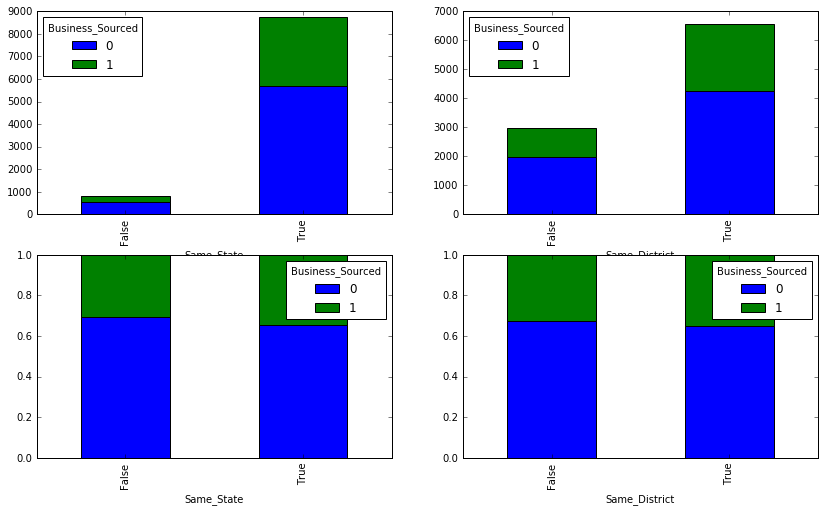

In [364]:
col = ["Same_State","Same_District"]
fig,ax=plt.subplots(2,2,figsize=[14,8])
df_train["Same_State"] = df_train.Applicant_Statename == df_train.Office_Statename
ct = pd.crosstab(df_train["Same_State"],df_train['Business_Sourced'],margins=True)
#ct = ct.apply(percConvert,axis=1)
ct.iloc[:-1,:-1].plot(kind='bar',stacked=True,ax=ax[0,0])

df_train["Same_State"] = df_train.Applicant_Statename == df_train.Office_Statename
ct = pd.crosstab(df_train["Same_State"],df_train['Business_Sourced'],margins=True)
ct = ct.apply(percConvert,axis=1)
ct.iloc[:-1,:-1].plot(kind='bar',stacked=True,ax=ax[1,0])

df_train["Same_District"] = df_train.Applicant_Districtname == df_train.Office_Districtname
ct = pd.crosstab(df_train["Same_District"],df_train['Business_Sourced'],margins=True)
#ct = ct.apply(percConvert,axis=1)
ct.iloc[:-1,:-1].plot(kind='bar',stacked=True,ax=ax[0,1])

df_train["Same_District"] = df_train.Applicant_Districtname == df_train.Office_Districtname
ct = pd.crosstab(df_train["Same_District"],df_train['Business_Sourced'],margins=True)
ct = ct.apply(percConvert,axis=1)
ct.iloc[:-1,:-1].plot(kind='bar',stacked=True,ax=ax[1,1])

plt.show()

#### - Integer data

In [187]:
data_types['integers']

['Manager_Grade',
 'Manager_Num_Application',
 'Manager_Num_Coded',
 'Manager_Num_Products',
 'Manager_Num_Products2',
 'Manager_Business',
 'Manager_Business2']

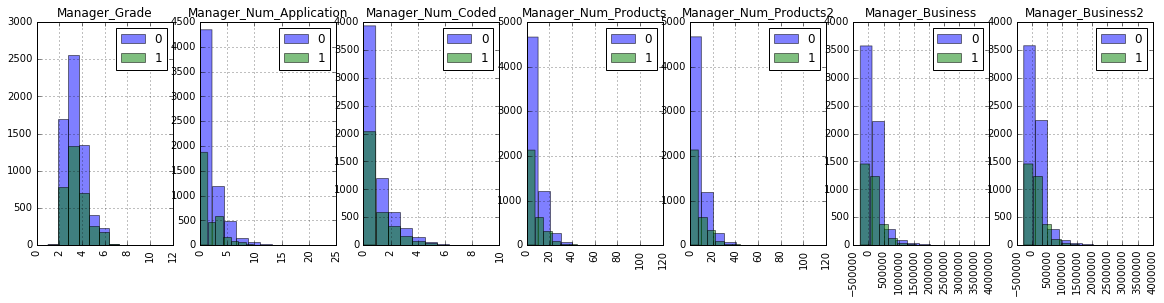

In [188]:
fig,ax = plt.subplots(1,7,figsize=[20,4])
for col in data_types['integers']:
    df_train[col][df_train.Business_Sourced == 0].hist(alpha=0.5,ax=ax[data_types['integers'].index(col)],xrot=90)
    df_train[col][df_train.Business_Sourced == 1].hist(alpha=0.5,ax=ax[data_types['integers'].index(col)],xrot=90)
    ax[data_types['integers'].index(col)].set_title(col)
    ax[data_types['integers'].index(col)].legend([0,1], loc='best')
plt.show()

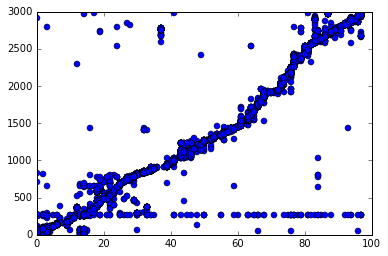

In [197]:
plt.plot(label_encoders['Office_PIN'].transform(df_train['Office_PIN']),
         label_encoders['Applicant_City_PIN'].transform(df_train['Applicant_City_PIN']),'o')
plt.show()


In [198]:
df_train['Office_PIN'][0]

842001